In [1]:
import requests
import time
import random
import json
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from src.graph_embeddings.data_util import MalwareGraph

plt.rcParams['figure.figsize'] = [10, 10]

In [119]:
mg = MalwareGraph('../edge_lists/bin_dll_func.csv', 400)
mg.get_vt_attributes('../VT_Scans.json')

In [120]:
arthrograph = nx.Graph()

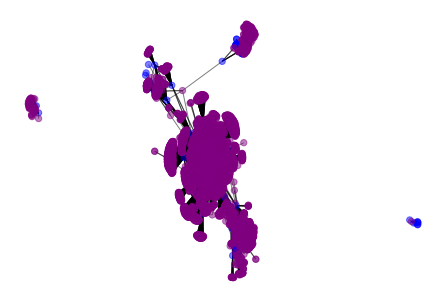

In [121]:
arthrograph.add_nodes_from(mg.files, bipartite=0)
arthrograph.add_nodes_from(mg.funcs, bipartite=1)

arthrograph.add_edges_from(mg.file_funcs)

color_map = []
for node in arthrograph:
    if node in mg.files:
        color_map.append('blue')
    elif node in mg.dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

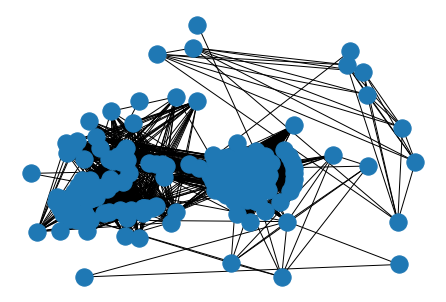

In [122]:
file_graph = bipartite.weighted_projected_graph(arthrograph, mg.files, ratio=True)
nx.draw(file_graph)

Deepwalk Implementation

In [123]:
from numpy.random import choice

def choose_neighbor(G, node):
    fs = []
    ws = []
    for x in G[node].items():
        fs.append(x[0])
        ws.append(x[1]['weight'])
        
    if len(ws) > 0:
        norm = [float(i)/sum(ws) for i in ws]
        draw = choice(fs, 1, p=norm)[0]
    else:
        draw = node

    return draw

In [124]:
walks_per_node = 10
walk_length = 80
walks = []
for node in file_graph:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = choose_neighbor(file_graph, cur_node)
            walk.append(next_node)
            cur_node = next_node
        walks.append(walk)
        node_walks += 1

In [125]:
model = Word2Vec(walks, size=16, window=5, min_count=1, sg=1, hs=0, negative=5, ns_exponent=0.75, iter=5)

In [126]:
kas_dict = {}
for scan, node in zip(mg.responses, mg.scanned_nodes):
    if 'scans' in scan:
        kaspersky = scan['scans'].get('Kaspersky')
        if kaspersky:
            result = kaspersky['result']
        else:
            result = None
        kas_dict[node] = result
    else:
        kas_dict[node] = None

In [158]:
overlaps = []
similarities = []
for node in mg.files:
    node_label = kas_dict[node]
    for k in model.wv.most_similar(node, topn=10):
        k_label = kas_dict[k[0]]
        if node_label and k_label:
            count = 0
            for token in node_label.split('.'):
                if token in k_label.split('.'):
                    count += 1
            overlap = count / len(node_label.split('.'))
            overlaps.append(overlap)
            similarities.append(k[1])
    

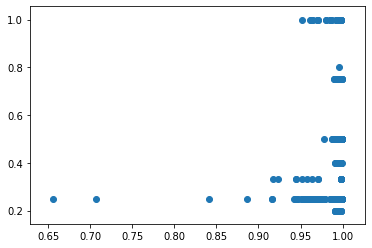

In [159]:
plt.scatter(similarities, overlaps)

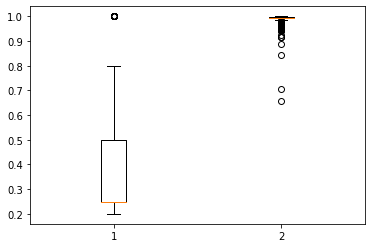

In [160]:
data = [overlaps, similarities]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.boxplot(data);

In [152]:
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

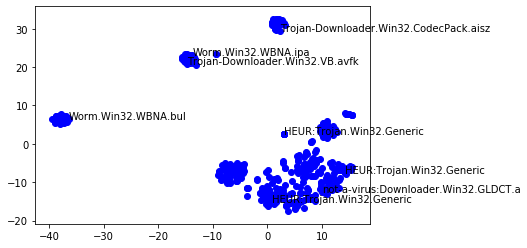

In [131]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for word, pos in df.iterrows():
    if word in mg.files:
        pt_color = 'blue'
        ax.scatter(pos[0], pos[1], color=pt_color)
        for r in mg.responses:
            if r['resource'] == word:
                response = r
        scan = None
        if 'scans' in response and 'Kaspersky' in response['scans']:
            scan = response['scans']['Kaspersky']['result']
            if random.uniform(0, 1) < 0.05:
                ax.annotate(scan, (pos[0], pos[1]))
    elif word in dlls: 
        pt_color = 'green'
    else:
        pt_color = 'purple'
        
    